# return study

In [360]:
import numpy as np
import pykep as pk
from pykep.planet import jpl_lp
from pykep import epoch
import pygmo as pg
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import spiceypy as spice

%matplotlib notebook

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [361]:
os.environ.get("SPICE")

'/home/yuri/Documents/spice'

In [375]:
import sys
sys.path.append("../")
import pyxplorer as pxp

In [381]:
pk.util.load_spice_kernel(os.path.join(os.environ.get("SPICE"), "spk", "de440.bsp"))
pk.util.load_spice_kernel(os.path.join(os.environ.get("SPICE"), "lsk", "naif0012.tls"))

In [382]:
ssdict = pxp.solar_system_spice()
ssdict["earth"]

Planet Name: 3, SUN, ECLIPJ2000
Own gravity parameter: 398600441800000
Central body gravity parameter: 1.32712440018e+20
Planet radius: 6378000
Planet safe radius: 6696900
Target planet: 3
Observer: SUN
Reference frame: ECLIPJ2000
Aberrations: NONE
Ephemerides type: SPICE Toolbox

In [383]:
epoch(13000,"mjd2000"), epoch(15000,"mjd2000")

(2035-Aug-05 00:00:00, 2041-Jan-25 00:00:00)

In [405]:
seq = [
    ssdict['saturn'],
    ssdict['saturn'],
    ssdict['earth']
]

prob_return = pk.trajopt.mga_1dsm(
    seq = seq,
    t0 = [
        epoch(12000,"mjd2000"),
        epoch(13000,"mjd2000"),
        #pk.epoch_from_string('2020-01-20 23:59:54.003').mjd,
        #pk.epoch_from_string('2030-01-20 23:59:54.003').mjd
    ], 
    tof = [
        [2/pk.DAY2YEAR, 6/pk.DAY2YEAR],
        [3/pk.DAY2YEAR, 6/pk.DAY2YEAR],
    ], 
    vinf = [0.0, 0.0], 
    multi_objective = False, 
    add_vinf_dep = True, 
    add_vinf_arr = False,
    tof_encoding = 'direct'
)

In [406]:
prob_return.fitness(pop.champion_x)

(5755.436751554479,)

In [407]:
algo = pg.algorithm(pg.sade(gen=4000))

In [408]:
print("Evolving...")
pop = pg.population(prob=prob_return, size=30)
pop = algo.evolve(pop)
print("Done!")

Evolving...
Done!


In [409]:
def iterate_launch_windows(seq, t0, tof):
    prob_iter = pk.trajopt.mga_1dsm(
        seq = seq,
        t0 = t0,
        tof=tof,
        vinf = [0.0, 0.0], 
        multi_objective = False, 
        add_vinf_dep = True, 
        add_vinf_arr = False,
        tof_encoding = 'direct'
    )
    pop = pg.population(prob=prob_iter, size=10)
    algo = pg.algorithm(pg.sade(gen=200))
    pop = algo.evolve(pop)
    return prob_iter, pop

In [410]:
tof = [
    [2/pk.DAY2YEAR, 6/pk.DAY2YEAR],
    [3/pk.DAY2YEAR, 6/pk.DAY2YEAR],
]

pop_list = []
prop_list = []

for i_window in tqdm(range(50)):
    t0_iter = [
        epoch(11000+i_window*100,"mjd2000"),
        epoch(11000+(i_window+1)*100,"mjd2000"),
        
    ]
    prob_iter, pop = iterate_launch_windows(seq, t0_iter, tof)
    try:
        pop_list.append(pop)
        prop_list.append(prob_iter)
    except:
        print(f"Failed at window {i_window}")

  0%|          | 0/50 [00:00<?, ?it/s]

In [411]:
# get combined list of xs and fs
for idx,pop_iter in enumerate(pop_list):
    if idx == 0:
        x_combined = pop_iter.get_x()
        f_combined = pop_iter.get_f()
    else:
        x_combined = np.concatenate((x_combined, pop_iter.get_x()),axis=0)
        f_combined = np.concatenate((f_combined, pop_iter.get_f()))

In [415]:
xbest = x_combined[np.argmin(f_combined),:]

<IPython.core.display.Javascript object>


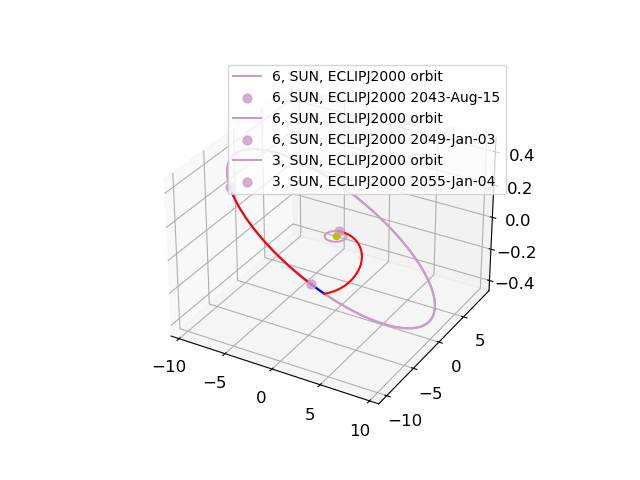

AttributeError: 'Axes3DSubplot' object has no attribute 'set_legend'

In [430]:
ax = prop_list[0].plot(xbest)
ax.set_legend(None)

In [412]:
#pop_iter.get_x()

In [413]:
x_combined.shape

(500, 10)

In [414]:
prob_return.pretty(pop.champion_x)

First Leg: 6, SUN, ECLIPJ2000 to 6, SUN, ECLIPJ2000
Departure: 2043-Aug-15 08:01:56.220031 (15932.334678472576 mjd2000) 
Duration: 1968.338416134589days
VINF: 0.0 km/sec
DSM after 200.01269194848857 days
DSM magnitude: 16.314181500156295m/s

leg no. 2: 6, SUN, ECLIPJ2000 to 3, SUN, ECLIPJ2000
Duration: 2191.4256946040996days
Fly-by epoch: 2049-Jan-03 16:09:15.374059 (17900.673094607166 mjd2000) 
Fly-by radius: 29.579198434529363 planetary radii
DSM after 219.24675001436862 days
DSM magnitude: 5435.9577851962995m/s

Arrival at 3, SUN, ECLIPJ2000
Arrival epoch: 2055-Jan-04 02:22:15.387853 (20092.098789211264 mjd2000) 
Arrival Vinf: 10399.099126596218m/s
Total mission time: 11.388813444869783 years (4159.764110738688 days)


In [396]:
# pretty_outside(prob_return, pop.champion_x)

```
direct encoding: [t0] + [u, v, Vinf, eta1, T1] + [beta, rp/rV, eta2, T2] + ... 
```

In [397]:
def porkchop_process(pop_x, pop_f):
    # extract from decision vector
    data = {
        "t0": [],
        "tof_total": [],
        "f": []
    }
    for idx, x in enumerate(pop_x):
        data["t0"].append(x[0])
        # get tof
        tof_total = x[5]
        for i_leg in range(len(seq)-2):
            tof_total += x[5+4*(i_leg+1)]
        data["tof_total"].append(tof_total)
        # objective
        data["f"].append(pop_f[idx])
    # convert to numpy array
    data["t0"] = np.array(data["t0"])
    data["tof_total"] = np.array(data["tof_total"])
    data["f"] = np.array(data["f"])
    return data

In [398]:
porkchop_return = porkchop_process(x_combined, f_combined)
#porkchop_return = porkchop_process(pop.get_x(), pop.get_f())

In [399]:
seq_name = ""
for se in seq:
    seq_name += se.name + "-"
seq_name = seq_name[:-1]
seq_name

'6, SUN, ECLIPJ2000-6, SUN, ECLIPJ2000-3, SUN, ECLIPJ2000'

In [400]:
seq_name = "saturn-saturn-earth"

<IPython.core.display.Javascript object>


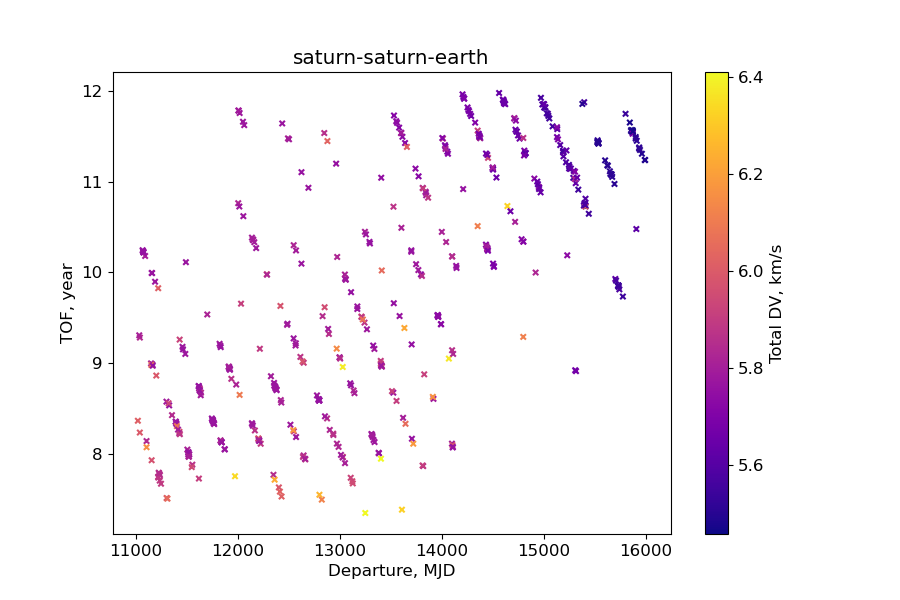

In [401]:
plt.rcParams["font.size"] = 12

fig, ax = plt.subplots(1,1,figsize=(9,6))

im0 = ax.scatter(porkchop_return['t0'], porkchop_return['tof_total']*pk.DAY2YEAR, 
                     c=porkchop_return['f']/1e3, cmap='plasma', s=15, marker='x')

fig.colorbar(im0, label='Total DV, km/s')
ax.set_title(seq_name)
ax.set(xlabel="Departure, MJD", ylabel="TOF, year")

plt.show()

In [403]:
epoch(11000,"mjd2000"), epoch(16000,"mjd2000")

(2030-Feb-12 00:00:00, 2043-Oct-22 00:00:00)

```
pykep.planet.keplerian(when,r,v, mu_central_body, mu_self,radius, safe_radius [, name = 'unknown'])
```

In [404]:
fig.savefig("./plots/return_pc_"+seq_name+".png")

In [187]:
# prob_return.plot(pop.champion_x)
# plt.show()